In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.8/874.8 kB 47.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Helper functions

def load_image_and_mask(image_path, mask_path):

    # Load image
    image = Image.open(image_path)
    image_array = np.array(image)  # Convert to NumPy array

    # Load mask
    mask = Image.open(mask_path)
    mask_array = np.array(mask)  # Convert to NumPy array

    return image_array, mask_array



def visualize_image_and_mask(image, mask, title_image="Image", title_mask="Segmentation Mask"):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    axes[0].imshow(image)
    axes[0].set_title(title_image)
    axes[0].axis('off')  # Hide axes for better visualization

    # Display the segmentation mask
    axes[1].imshow(mask, cmap='gray')  # Use cmap='gray' to display the mask in grayscale
    axes[1].set_title(title_mask)
    axes[1].axis('off')  # Hide axes for better visualization

    # Show the plots
    plt.tight_layout()
    plt.show()


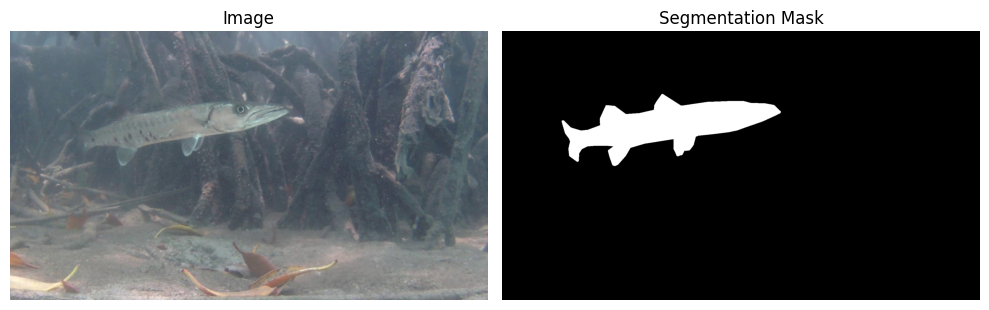

In [ ]:
image_path = '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Segmentation/images/valid/7398_F6_f000120.jpg'
mask_path = image_path.replace('images', 'masks').replace('.jpg', '.png')

image, mask = load_image_and_mask(image_path, mask_path)

visualize_image_and_mask(image, mask)

In [ ]:
# prompt: make a code that goes through the folders with paths:
# '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Localization/images/valid' and /content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Localization/masks/valid
# And counts the total number of images that have a matching mask.

def count_matching_images_and_masks(image_folder, mask_folder):
  """
  Counts the number of images with matching masks in two folders.

  Args:
    image_folder: Path to the folder containing images.
    mask_folder: Path to the folder containing masks.

  Returns:
    int: The number of matching images and masks.
  """

  image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
  mask_files = [f.replace('.jpg', '.png') for f in image_files]

  count = 0
  for mask_file in mask_files:
    if mask_file in os.listdir(mask_folder):
      count += 1

  return count

# Paths to the image and mask folders
image_folder = '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Localization/images/valid'
mask_folder = '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Localization/masks/valid'

# Count the matching images and masks
matching_count = count_matching_images_and_masks(image_folder, mask_folder)

print(f"Total matching images and masks: {matching_count}")


KeyboardInterrupt: 

In [ ]:
# prompt: Implement yolov10n so it is fed an image and it prints out the image with the boundary boxes of what it detects. Make it so it runs in 5 random images of  '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Localization/images/valid'


# Load the YOLOv8n model
model = YOLO('yolov10n.pt')

# Path to the image folder
image_folder = '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Localization/images/valid'

# Get a list of image files
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Select 5 random images
random_images = random.sample(image_files, 5)

# Process each image
for image_file in random_images:
    image_path = os.path.join(image_folder, image_file)

    # Run YOLOv8n inference
    results = model(image_path)

    # Visualize the results
    for result in results:
        im_array = result.plot()  # plot a BGR image with bounding boxes
        im = Image.fromarray(im_array[..., ::-1])  # Convert BGR to RGB
        plt.imshow(im)
        plt.title(f"Image: {image_file}")
        plt.show()



In [ ]:


def extract_bounding_boxes_from_mask(mask):
    """
    Extract bounding boxes from the binary segmentation mask.
    """
    # Convert mask to grayscale
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale mask to create a binary image
    _, binary_mask = cv2.threshold(gray_mask, 1, 255, cv2.THRESH_BINARY)

    # Find contours (external contours)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # List to store bounding boxes
    bounding_boxes = []

    # Loop over contours and get bounding boxes
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append([x, y, x + w, y + h])  # x_min, y_min, x_max, y_max

    return bounding_boxes

def draw_bounding_boxes_on_image(image, bounding_boxes):
    """
    Draw bounding boxes on the image.
    """
    for box in bounding_boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green boxes

    return image

def process_image_and_mask(image_path, mask_path, output_image_path=None):
    """
    Process a single image and its corresponding mask.
    Extract bounding boxes from the mask and draw them on the image.
    """
    # Load the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    # Extract bounding boxes from the mask
    bounding_boxes = extract_bounding_boxes_from_mask(mask)

    # Draw bounding boxes on the image
    image_with_boxes = draw_bounding_boxes_on_image(image, bounding_boxes)

    # Save the output image with bounding boxes (if specified)
    if output_image_path:
        cv2.imwrite(output_image_path, image_with_boxes)

    return image_with_boxes, bounding_boxes

def process_directory(image_dir, mask_dir, output_dir):
    """
    Iterate through all images and masks in the directories and process them.
    """
    # Get all image and mask filenames
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each image and mask pair
    for image_file, mask_file in zip(image_files, mask_files):
        # Check if the filenames (without extension) match
        if os.path.splitext(image_file)[0] == os.path.splitext(mask_file)[0]:
            image_path = os.path.join(image_dir, image_file)
            mask_path = os.path.join(mask_dir, mask_file)
            output_image_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_with_boxes.jpg")

            # Process the image and mask
            image_with_boxes, bounding_boxes = process_image_and_mask(image_path, mask_path, output_image_path)

            # Print the bounding boxes for each image
            print(f"Processed {image_file}: Bounding boxes: {bounding_boxes}")
        else:
            print(f"Skipping {image_file} and {mask_file}: filenames do not match")

image_dir = '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Segmentation/images/valid'
mask_dir = '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Segmentation/masks/valid'
output_dir = f'/content/drive/MyDrive/Fishes'

#process_directory(image_dir, mask_dir, output_dir)


In [ ]:


def extract_bounding_boxes(mask):
    """Extract bounding boxes from a binary mask using OpenCV."""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        boxes.append((x, y, w, h))
    return boxes

def convert_to_yolo_format(image_size, bounding_box):
    """Convert bounding box to YOLO format."""
    img_width, img_height = image_size
    x, y, w, h = bounding_box

    # Calculate center coordinates and normalize
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    norm_width = w / img_width
    norm_height = h / img_height

    return (x_center, y_center, norm_width, norm_height)

def process_masks(mask_folder, output_folder, class_id=0):
    """Process all masks in the mask_folder, create YOLO .txt files in output_folder."""
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Loop over all mask images
    for mask_file in os.listdir(mask_folder):
        if mask_file.endswith(".png") or mask_file.endswith(".jpg"):
            # Read the mask image
            mask_path = os.path.join(mask_folder, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Extract image dimensions
            img_height, img_width = mask.shape

            # Extract bounding boxes from the mask
            boxes = extract_bounding_boxes(mask)

            # Prepare output .txt file path
            base_filename = os.path.splitext(mask_file)[0]
            output_txt_path = os.path.join(output_folder, f"{base_filename}.txt")

            with open(output_txt_path, 'w') as f:
                # Write each bounding box in YOLO format to the output file
                for box in boxes:
                    yolo_box = convert_to_yolo_format((img_width, img_height), box)
                    x_center, y_center, norm_width, norm_height = yolo_box
                    # Write class_id and bounding box information to the .txt file
                    f.write(f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n")
            print(f"Processed {mask_file}, saved to {output_txt_path}")

process_masks(mask_dir, output_dir)




Processed 7398_F2_f000050.png, saved to /content/drive/MyDrive/Fishes/7398_F2_f000050.txt
Processed 7117_Lutjanus_argentimaculatus_adult_2_f000050.png, saved to /content/drive/MyDrive/Fishes/7117_Lutjanus_argentimaculatus_adult_2_f000050.txt
Processed 7398_F6_f000060.png, saved to /content/drive/MyDrive/Fishes/7398_F6_f000060.txt


In [ ]:
# Load a pre-trained YOLO model
model = YOLO('yolov10n.pt')

# Train the model on datasete
model.train(
    data='/content/drive/MyDrive/Yolov8_dataset_full/data.yaml',  # Path to the data.yaml file
    epochs=100,  # Number of epochs
    imgsz=640,   # Image size (default is 640x640)
    batch=16,    # Batch size
    patience = 20, # How many epochs without change to stop
    name='16-09-2024-1123'  # Name of your training run
)

100%|██████████| 5.59M/5.59M [00:00<00:00, 93.6MB/s]


Ultralytics YOLOv8.2.94 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/drive/MyDrive/Yolov8_dataset_full/data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=16-09-2024-1123, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

100%|██████████| 755k/755k [00:00<00:00, 21.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 98.7MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Yolov8_dataset_full/train/labels... 434 images, 217 backgrounds, 0 corrupt: 100%|██████████| 434/434 [01:30<00:00,  4.81it/s]


train: New cache created: /content/drive/MyDrive/Yolov8_dataset_full/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Yolov8_dataset_full/valid/labels... 124 images, 62 backgrounds, 0 corrupt: 100%|██████████| 124/124 [00:25<00:00,  4.80it/s]

val: New cache created: /content/drive/MyDrive/Yolov8_dataset_full/valid/labels.cache


Plotting labels to runs/detect/16-09-2024-1123/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/16-09-2024-1123
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.12G      2.612      16.87      2.877          2        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        124         80    0.00169      0.787      0.122     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.04G       3.15      14.14      3.101          2        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all        124         80    0.00142      0.662     0.0451     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.04G      3.318      13.23      3.137          1        640: 100%|██████████| 28/28 [00:10<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        124         80       0.19      0.125     0.0867     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.05G      3.702      11.99      3.433          4        640: 100%|██████████| 28/28 [00:10<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]

                   all        124         80    0.00307      0.175    0.00149   0.000526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.04G      3.449       10.2      3.211          0        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        124         80     0.0355      0.125     0.0342     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.05G      3.701      8.733      3.426          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        124         80     0.0924      0.163     0.0654      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.05G      3.479      7.376      3.268          2        640: 100%|██████████| 28/28 [00:11<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

                   all        124         80     0.0524      0.075      0.017    0.00606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.04G      3.559      7.199      3.429          1        640: 100%|██████████| 28/28 [00:09<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        124         80      0.421      0.188      0.198     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.04G      3.322      5.687      3.176          2        640: 100%|██████████| 28/28 [00:11<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        124         80      0.174      0.175      0.103     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.04G      3.338      5.459      3.153          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        124         80      0.474      0.287      0.297      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.05G      3.425      4.883      3.165          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        124         80      0.206      0.375      0.175     0.0811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.04G      3.294      4.611      3.072          1        640: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        124         80      0.447      0.404      0.421      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.04G      3.215      4.397      3.121          2        640: 100%|██████████| 28/28 [00:10<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        124         80      0.696       0.45      0.484      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.04G        3.2      4.227      2.996          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        124         80      0.267        0.1     0.0839      0.045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.05G       3.13      3.827      2.949          5        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

                   all        124         80      0.401      0.352      0.326       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.04G      3.071      3.562      2.968          1        640: 100%|██████████| 28/28 [00:11<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        124         80      0.265      0.125     0.0746     0.0377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.05G      3.154      3.916      3.068          6        640: 100%|██████████| 28/28 [00:09<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        124         80      0.594      0.362       0.37      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.04G      2.882      3.518      2.888          0        640: 100%|██████████| 28/28 [00:10<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all        124         80      0.751      0.475      0.571      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.04G      2.952      3.568      2.924          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

                   all        124         80      0.482       0.36      0.341      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.04G      2.837      3.247      2.768          0        640: 100%|██████████| 28/28 [00:12<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        124         80      0.522      0.613      0.593      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.04G      2.937      3.552      2.903          5        640: 100%|██████████| 28/28 [00:10<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        124         80      0.632       0.45      0.491      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.05G      3.015      3.525      2.927          6        640: 100%|██████████| 28/28 [00:09<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        124         80      0.653      0.684      0.746      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.04G      2.794      3.077      2.821          2        640: 100%|██████████| 28/28 [00:12<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        124         80      0.728      0.702      0.723      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.04G      2.847      3.003      2.797          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        124         80      0.631       0.65      0.683      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.04G      2.708      2.762      2.721          2        640: 100%|██████████| 28/28 [00:11<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        124         80      0.783        0.6      0.711      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.04G      2.699      2.713      2.738          1        640: 100%|██████████| 28/28 [00:09<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        124         80      0.658      0.457      0.547      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.04G      2.715      2.903      2.797          4        640: 100%|██████████| 28/28 [00:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        124         80      0.653      0.675      0.672      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.04G       2.79      2.942      2.778          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        124         80      0.676      0.613      0.625      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.04G      2.594      2.667      2.642          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        124         80      0.693      0.688      0.712      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.05G      2.491      2.444      2.592          7        640: 100%|██████████| 28/28 [00:11<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        124         80      0.772      0.637      0.723      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.04G      2.563      2.486      2.609          0        640: 100%|██████████| 28/28 [00:09<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        124         80      0.741      0.643      0.725      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.04G      2.502      2.425      2.614          1        640: 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        124         80      0.814      0.675      0.801      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.04G      2.457       2.45      2.484          0        640: 100%|██████████| 28/28 [00:13<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        124         80      0.678        0.7      0.699      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.04G      2.496       2.72      2.655          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        124         80      0.883      0.662      0.781      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.04G      2.383      2.346      2.468          0        640: 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        124         80      0.692      0.647      0.716      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.04G      2.363      2.332      2.589          2        640: 100%|██████████| 28/28 [00:10<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        124         80      0.732      0.625      0.671      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.04G      2.414      2.463      2.607          2        640: 100%|██████████| 28/28 [00:12<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        124         80       0.66       0.75      0.701      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.04G      2.373      2.206      2.525          2        640: 100%|██████████| 28/28 [00:13<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

                   all        124         80      0.739      0.708      0.745      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.04G      2.307      2.203      2.443          0        640: 100%|██████████| 28/28 [00:10<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        124         80      0.787      0.588      0.697      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.04G      2.438      2.176      2.576          2        640: 100%|██████████| 28/28 [00:09<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]

                   all        124         80      0.759      0.787      0.793      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.04G      2.247      2.125      2.415          1        640: 100%|██████████| 28/28 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

                   all        124         80      0.748       0.75      0.803      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.04G      2.133      1.973      2.331          0        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        124         80      0.773      0.722      0.788      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.04G      2.264      2.102      2.471          1        640: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        124         80      0.813      0.688      0.817      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.04G      2.214      2.133      2.476          3        640: 100%|██████████| 28/28 [00:09<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        124         80      0.842      0.797      0.847      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.04G       2.24      2.207      2.371          0        640: 100%|██████████| 28/28 [00:10<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        124         80      0.844       0.65      0.738       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.04G      2.295      2.215      2.475          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

                   all        124         80      0.829      0.762      0.856       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.04G      2.227      2.037      2.453          5        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        124         80      0.901      0.796      0.869      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.04G      2.171       1.89      2.459          3        640: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        124         80      0.886      0.779      0.864      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.04G      2.079      1.936      2.363          2        640: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        124         80      0.766      0.812      0.834      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.04G      2.139      1.814      2.394          1        640: 100%|██████████| 28/28 [00:10<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all        124         80      0.788      0.698      0.807      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.04G      2.118      1.772      2.431          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        124         80       0.78      0.675      0.753      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.04G      2.029      1.787      2.394          2        640: 100%|██████████| 28/28 [00:12<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        124         80      0.848      0.699      0.795      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.04G      2.075      1.929      2.423          2        640: 100%|██████████| 28/28 [00:10<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        124         80      0.859      0.725      0.832      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.04G      2.077      1.926      2.393          1        640: 100%|██████████| 28/28 [00:09<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

                   all        124         80      0.902      0.687      0.815      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.04G      2.123      1.854      2.399          4        640: 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        124         80      0.885      0.725      0.861      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.04G      2.026      1.688      2.327          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        124         80      0.791      0.688      0.798      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.04G       1.93       1.76      2.268          0        640: 100%|██████████| 28/28 [00:12<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        124         80      0.649      0.688      0.648      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.04G      1.995      1.705      2.301          2        640: 100%|██████████| 28/28 [00:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        124         80      0.806      0.637      0.753      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.04G       2.08      1.834      2.334          4        640: 100%|██████████| 28/28 [00:09<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        124         80       0.78      0.762      0.808      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.04G      1.907      1.714      2.248          1        640: 100%|██████████| 28/28 [00:11<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all        124         80       0.89      0.688       0.82      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.04G      2.009      1.724      2.358          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        124         80      0.826      0.711       0.76      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.04G      1.923      1.824      2.263          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        124         80      0.913       0.75      0.869      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.04G      1.939      1.695      2.294          2        640: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

                   all        124         80      0.893      0.812      0.882      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.04G      1.907      1.731      2.254          2        640: 100%|██████████| 28/28 [00:09<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all        124         80      0.805      0.838      0.886      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.04G       1.88      1.624      2.266          1        640: 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        124         80       0.88      0.775      0.867      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.04G      1.839      1.663      2.246          3        640: 100%|██████████| 28/28 [00:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all        124         80      0.875      0.787      0.876      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.04G      1.837      1.629      2.252          2        640: 100%|██████████| 28/28 [00:11<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        124         80      0.866      0.713      0.807       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.04G      1.721      1.465      2.134          1        640: 100%|██████████| 28/28 [00:09<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        124         80      0.936      0.738      0.846      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.04G      1.843      1.557      2.271          2        640: 100%|██████████| 28/28 [00:10<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all        124         80      0.824       0.76      0.849      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.04G      1.805      1.449       2.21          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        124         80      0.889      0.787      0.886      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.04G      1.823      1.435      2.218          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        124         80      0.917       0.83      0.899      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.04G      1.875      1.632      2.284          3        640: 100%|██████████| 28/28 [00:10<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        124         80      0.798      0.886      0.886      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.04G      1.777      1.533      2.186          0        640: 100%|██████████| 28/28 [00:09<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        124         80      0.924      0.825      0.883      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.04G      1.618      1.402      2.081          0        640: 100%|██████████| 28/28 [00:11<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        124         80      0.856      0.875      0.898      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.04G      1.533      1.316      2.091          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        124         80      0.934      0.787      0.902      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.04G      1.744      1.507      2.181          4        640: 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        124         80       0.88      0.825      0.889      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.04G      1.647      1.395      2.157          4        640: 100%|██████████| 28/28 [00:08<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all        124         80      0.911      0.825      0.896      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.04G      1.686      1.457      2.137          4        640: 100%|██████████| 28/28 [00:10<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        124         80      0.914      0.775      0.888      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.04G      1.651      1.383      2.105          0        640: 100%|██████████| 28/28 [00:11<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

                   all        124         80      0.852      0.838      0.884      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.04G      1.709      1.514      2.186          4        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        124         80      0.947      0.775      0.888       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.04G      1.674      1.297      2.159          1        640: 100%|██████████| 28/28 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        124         80      0.901        0.8      0.902      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.04G      1.636      1.273      2.201          2        640: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]

                   all        124         80      0.921      0.876      0.916      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.04G      1.509      1.342       2.03          2        640: 100%|██████████| 28/28 [00:12<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        124         80      0.926      0.787      0.898      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.04G      1.564       1.36      2.103          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

                   all        124         80      0.854      0.863      0.911      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.04G      1.581      1.316      2.106          4        640: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        124         80      0.929      0.823      0.905      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.04G      1.526      1.169      2.093          1        640: 100%|██████████| 28/28 [00:09<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

                   all        124         80       0.84       0.85      0.892      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.04G      1.666      1.348      2.185          2        640: 100%|██████████| 28/28 [00:12<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

                   all        124         80      0.866        0.8      0.884      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.04G       1.53      1.413      2.066          0        640: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all        124         80      0.925      0.765      0.897      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.04G      1.491      1.281      2.038          3        640: 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

                   all        124         80      0.905      0.836      0.896      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.04G      1.415      1.164      2.028          3        640: 100%|██████████| 28/28 [00:08<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        124         80      0.916       0.85      0.915      0.743


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.08G       1.32     0.9895      1.919          2        640: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        124         80      0.916      0.823      0.913      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.04G      1.252      1.005      1.875          0        640: 100%|██████████| 28/28 [00:11<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

                   all        124         80      0.904      0.825      0.893      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.04G      1.253     0.9862      1.963          2        640: 100%|██████████| 28/28 [00:13<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        124         80      0.905      0.829      0.898      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.04G      1.146     0.9045      1.882          1        640: 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        124         80      0.886      0.812      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.04G      1.123     0.8838      1.802          0        640: 100%|██████████| 28/28 [00:08<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        124         80      0.893      0.832        0.9      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.04G       1.18     0.9262      1.838          0        640: 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]

                   all        124         80      0.843       0.87      0.909      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.04G       1.18       0.92      1.853          2        640: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        124         80      0.854      0.887      0.911      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.04G      1.168     0.8394      1.858          1        640: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        124         80      0.895      0.887      0.918      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.04G       1.18     0.9364      1.893          1        640: 100%|██████████| 28/28 [00:09<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        124         80       0.91       0.85      0.915      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.04G      1.053     0.8792      1.884          1        640: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        124         80      0.883      0.863      0.912      0.742



100 epochs completed in 0.406 hours.
Optimizer stripped from runs/detect/16-09-2024-1123/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/16-09-2024-1123/weights/best.pt, 5.8MB

Validating runs/detect/16-09-2024-1123/weights/best.pt...
Ultralytics YOLOv8.2.94 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


                   all        124         80      0.919      0.849      0.915      0.745
Speed: 0.3ms preprocess, 3.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/16-09-2024-1123


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b11a4fad030>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
model = YOLO('/content/drive/MyDrive/Colab Notebooks/Results/LocSegCheckv10s.pt')
metrics = model.val()


Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8,036,508 parameters, 0 gradients, 24.4 GFLOPs


FileNotFoundError: 'C:\Users\Usuario\Desktop\TUE\Data Challenge 3\Datasets RoboFlow\DeepFish Loc+Seg, checked\data.yaml' does not exist

In [ ]:
model = YOLO('/content/runs/detect/16-09-2024-1123/weights/best.pt')
results = model('/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/DeepFish/Localization/images/valid/7117_Caranx_sexfasciatus_juvenile_f000040.jpg')
# Extract the first result (since it's returned as a list)
result = results[0]

# Draw bounding boxes on the original image using OpenCV
annotated_frame = result.plot()

# Convert the image from BGR to RGB (for displaying using matplotlib)
annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes using matplotlib
plt.imshow(annotated_frame)
plt.axis('off')  # Hide axes
plt.show()


NameError: name 'YOLO' is not defined